In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from helper_functions.arma_helper_functions import *
from helper_functions.comparison_helper_functions import *

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./data/train_data.npy')
y = np.load('./data/actual_train_labels.npy')
X_test = np.load('./data/test_data.npy')

train_data = pd.read_pickle('./data/train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

ss = StandardScaler()
X1_scaled = ss.fit_transform(X1)
X2_scaled = ss.fit_transform(X2)

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  492


### Visualize data to assess stationarity
The moments (mean and variance) of a stationary process are independent of time (remain constant). From the following plots we can safely assume that the assumption of stationarity holds, hence no differencing is required.

Text(0.5, 0, 'Day')

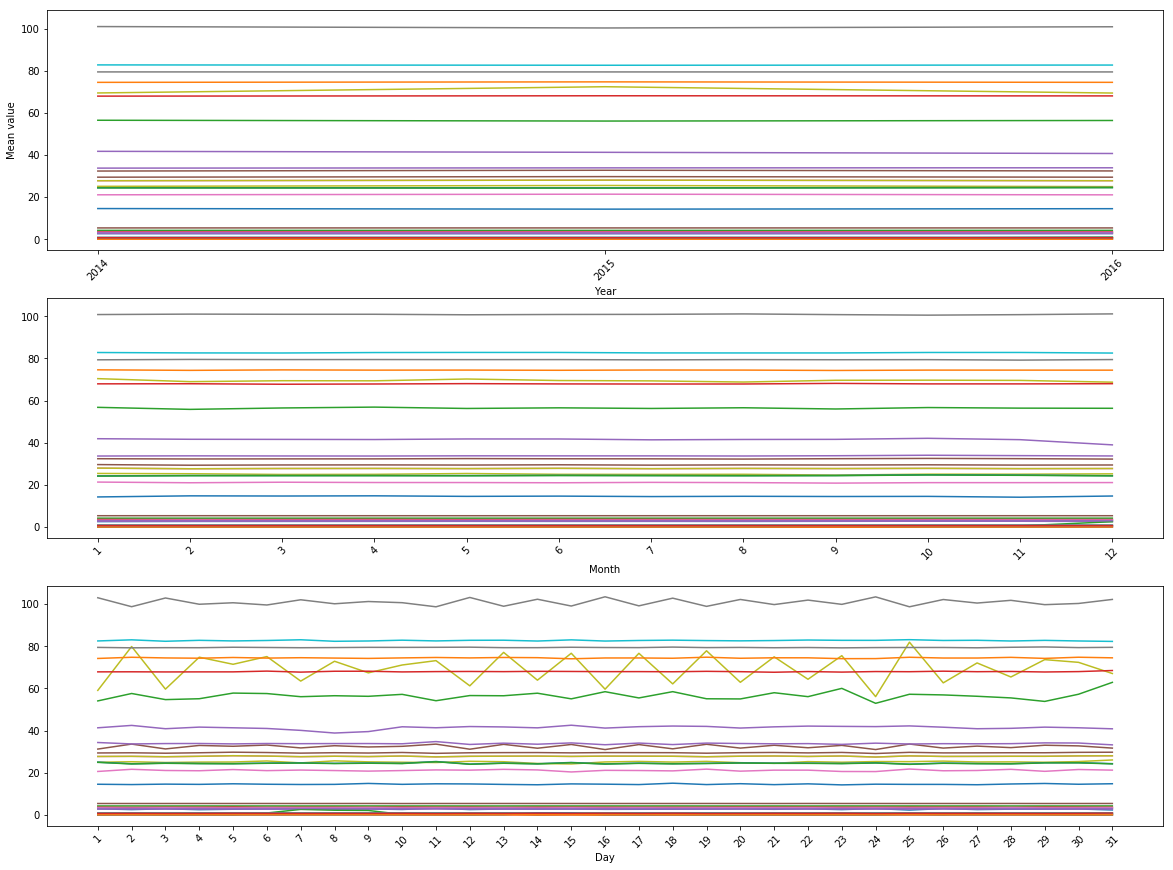

In [2]:
mean_yearly = train_data.drop(['Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['Year','Day', 'Hour'], axis=1).groupby(['Month']).mean()
mean_daily = train_data.drop(['Month', 'Year', 'Hour'], axis=1).groupby('Day').mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=3, ncols=1, figsize = (20, 15), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")

Text(0.5, 0, 'Day')

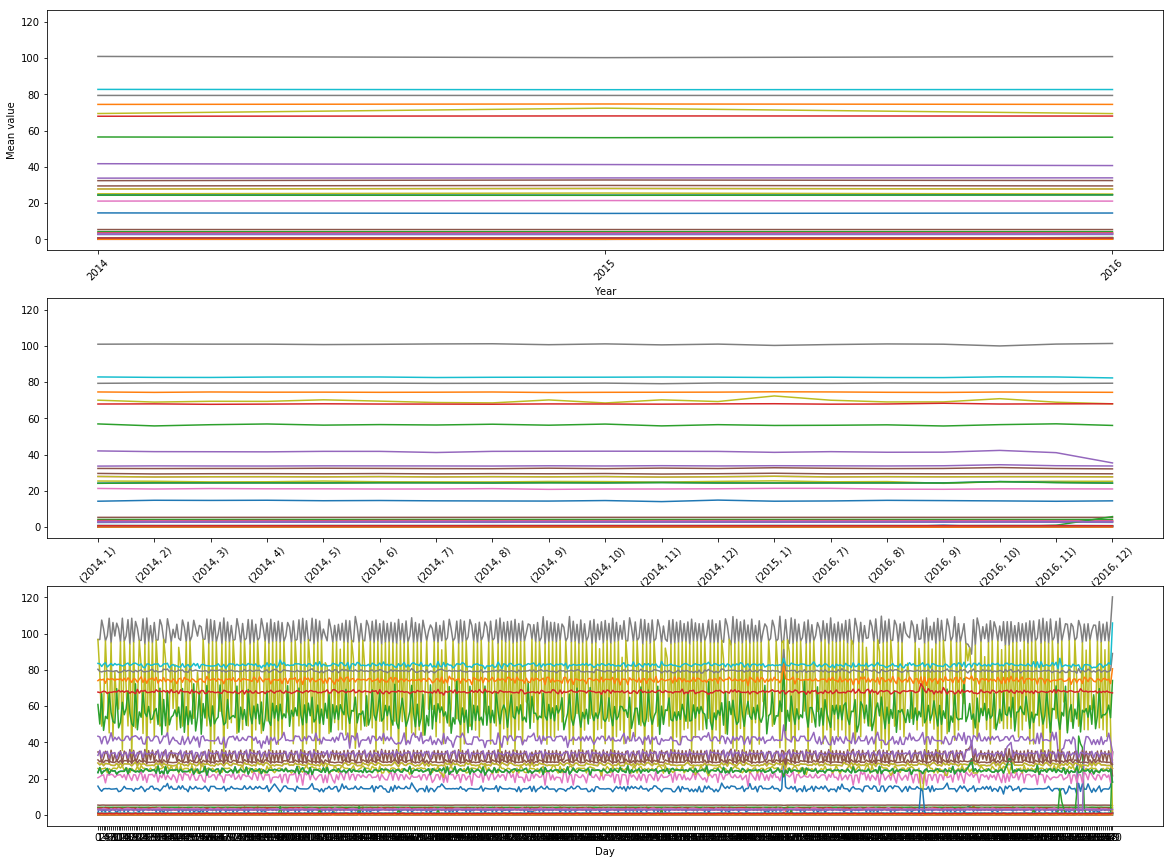

In [2]:
mean_yearly = train_data.drop(['Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['Day', 'Hour'], axis=1).groupby(['Year', 'Month']).mean()
mean_daily = train_data.drop(['Hour'], axis=1).groupby(['Year','Month','Day']).mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=3, ncols=1, figsize = (20, 15), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
# ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")


### ARMA

#### Examined sensor: `L_T1`
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_signal = X1_scaled[:, 0]
test_signal = X2_scaled[:, 0]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  -3794.61963064468
BIC:  -3773.385434646681
DW-test:  0.29607798174501454


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

Regarding `L_T1` we can see that there is positive correlation with both lagged versions of the signal, as well as with lagged residuals. Hence an ARMA method is indeed required. Regarding the Autcorrelation plot we can see that after 4 lags autocorrelation drops significantly. There are though significant autocorrelation for higher lag values, which is not a welcome effect, but we will prefer a simpler model (lower p value). Regarding the PACF plot there is significant drop after a single lag, hence we would choose for q=1.

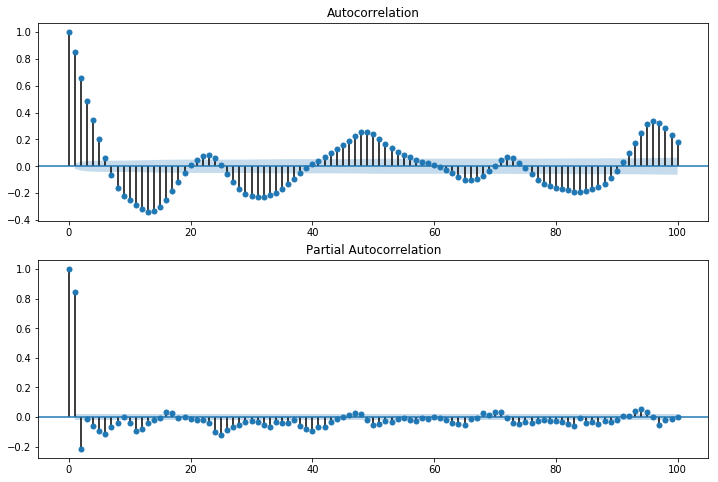

In [11]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [12]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q)

print(AIC)
print(f"Model with min AIC: {np.min(AIC)}, of order: ({opt_p}, {opt_q})")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likel

[[ -3794.61963064 -10988.97480412 -13813.23097474 -15015.37990416
  -15494.26509856 -15765.99051284]
 [-16274.84286551 -16502.85529826 -16523.21121116 -16537.79305255
  -16536.84697695 -16549.5990532 ]
 [-16465.60692701 -16514.48767208 -16648.92418213 -16647.76200619
  -16647.67588887 -16646.41689597]
 [-16539.17925422 -16623.32750417 -16647.61372585 -16647.4835059
  -16645.75264715 -16577.34929436]
 [-16543.2257136  -16650.31136254 -16638.76850283 -16645.84779692
  -16767.7283889  -16779.01235157]]
Model with min AIC: -16779.012351572575, of order: (5, 5)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Fit optimal model

In [4]:
# summary of the fitted model
opt_p, opt_q = 2, 1
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(2, 1)   Log Likelihood                8256.428
Method:                       css-mle   S.D. of innovations              0.094
Date:                Wed, 29 May 2019   AIC                         -16502.855
Time:                        21:06:02   BIC                         -16467.465
Sample:                             0   HQIC                        -16490.797
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.033     -0.030      0.976      -0.065       0.063
ar.L1.y        1.7890      0.007    258.285      0.000       1.775       1.803
ar.L2.y       -0.8257      0.007   -119.585      0.0

Max:  1.8006944934108355
Mean:  -0.00015603594965836847
std:  0.0961919772294352


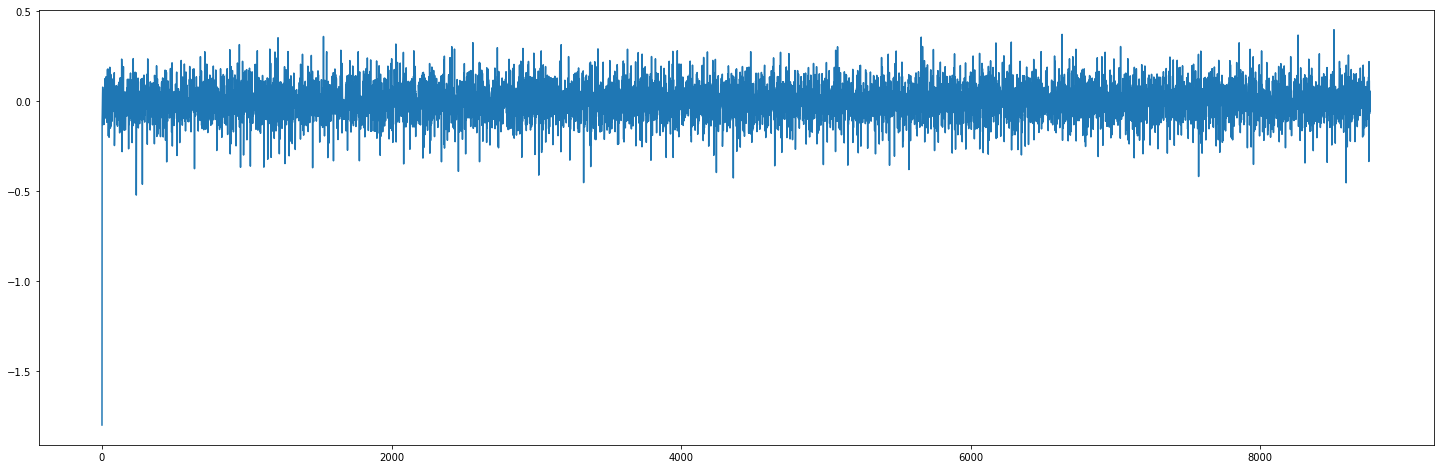

In [14]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [3]:
file = './data/arma_21_LT1_scaled.npy'
opt_p, opt_q = 2, 1
predictions, MFE, MAE, MAPE = predictS(train_signal, test_signal, opt_p, opt_q, file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)
print(f"MAPE: {MAPE*100}%")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:934: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)


MFE:  -0.00013640573662561598
MAE:  0.07890853019878076
MAPE: 26.16% 0.2616


Text(0, 0.5, 'L_T1')

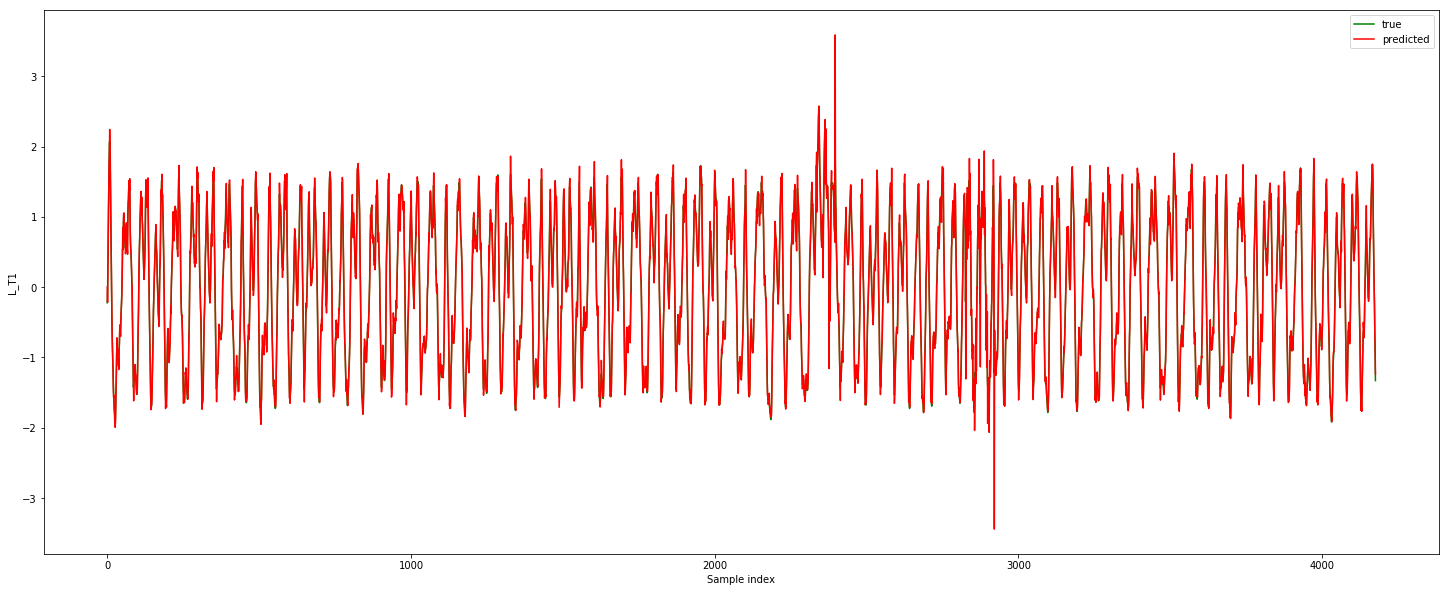

In [4]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

In [3]:
# predictions = np.load('data/arma_21_LT1_scaled.npy')
# opt_p, opt_q = 2, 1

multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.01
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

S:  [0.50681753 0.51495941 0.52221979 0.53328113 0.55714489 0.56627524
 0.56975368 0.56316068 0.54179204 0.53014308 0.5156281  0.50495078
 0.50287779 0.50287779 0.49938331 0.49951764 0.49682155] 

ind:  6


Confusion matrix:
 [[ 194  968]
 [ 298 2717]] 

Score: 0.570
Accuracy: 0.697
Precision: 0.167
Recall: 0.394
F1_score: 0.235


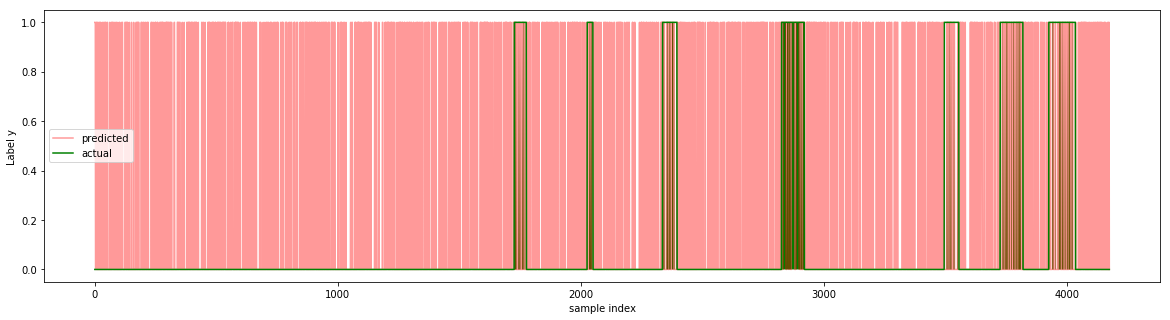

In [4]:
# ind = 6
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

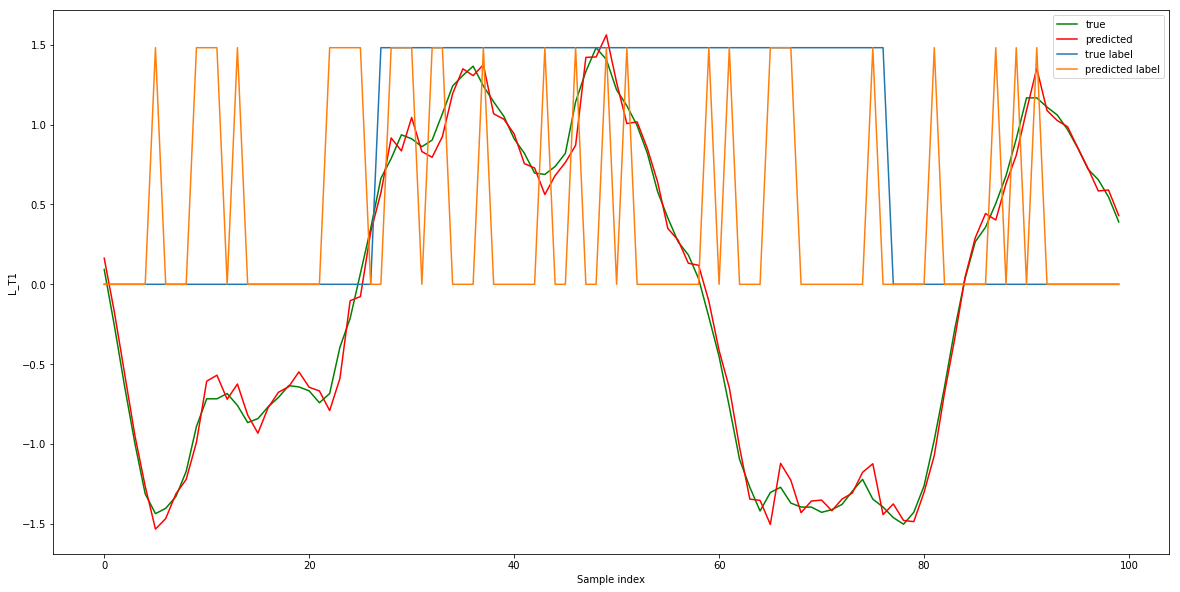

In [11]:
start = 1700
end = 1800

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*np.max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*np.max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

#### Examined sensor: `L_T3`
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_signal = X1_scaled[:, 2]
test_signal = X2_scaled[:, 2]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  13978.980724916408
BIC:  14000.214920914406
DW-test:  0.5515803077394407


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

Regarding `L_T1` we can see that there is positive correlation with both lagged versions of the signal, as well as with lagged residuals. Hence an ARMA method is indeed required. Regarding the Autcorrelation plot we can see that after 4 lags autocorrelation drops significantly. There are though significant autocorrelation for higher lag values, which is not a welcome effect, but we will prefer a simpler model (lower p value). Regarding the PACF plot there is significant drop after a single lag, hence we would choose for q=1.

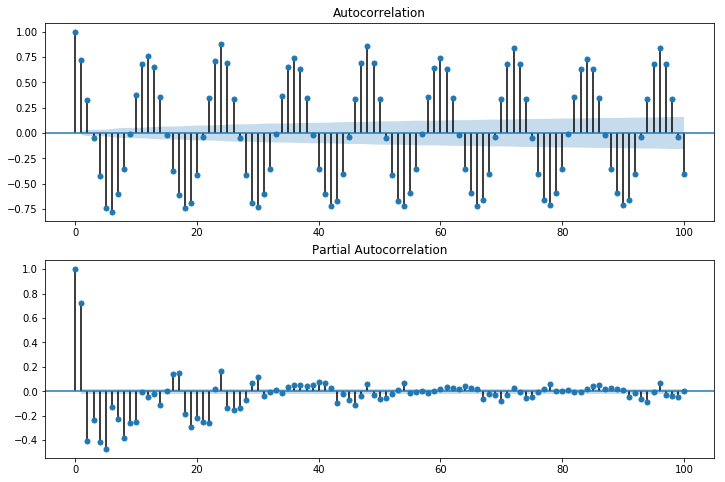

In [20]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [ ]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,10, dtype=int)

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q)

print(AIC)
print(f"Model with min AIC: {np.min(AIC)}, of order: ({opt_p}, {opt_q})")

Failed to fit ARMA model (0, 5)
Failed to fit ARMA model (0, 6)
Failed to fit ARMA model (0, 7)
Failed to fit ARMA model (0, 8)
Failed to fit ARMA model (0, 9)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likel

Failed to fit ARMA model (4, 6)
Failed to fit ARMA model (4, 7)


#### Fit optimal model

In [17]:
# summary of the fitted model
opt_p, opt_q = 4, 4
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(4, 4)   Log Likelihood                4290.484
Method:                       css-mle   S.D. of innovations              0.148
Date:                Wed, 29 May 2019   AIC                          -8560.968
Time:                        22:14:12   BIC                          -8490.187
Sample:                             0   HQIC                         -8536.851
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039        nan        nan        nan         nan         nan
ar.L1.y        3.5964        nan        nan        nan         nan         nan
ar.L2.y       -5.1503   3.11e-05  -1.65e+05      0.0

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Max:  0.8382427182257604
Mean:  0.00037033909131139016
std:  0.14849344099792125


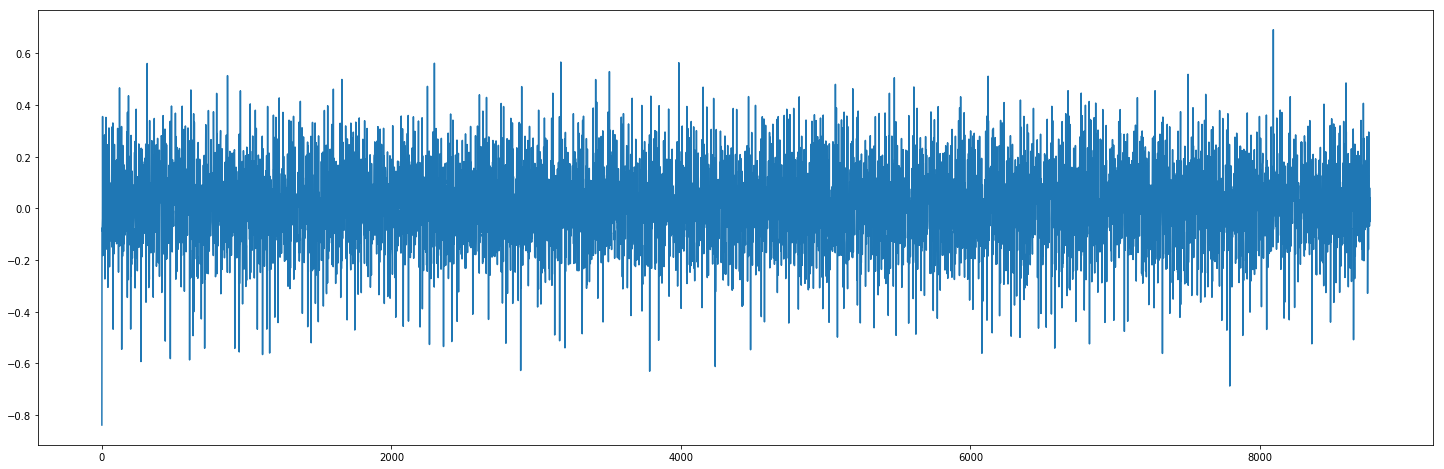

In [18]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [3]:
file = './data/arma_44_LT2_scaled.npy'
opt_p, opt_q = 4, 4
predictions, MFE, MAE, MAPE = predictS(train_signal, test_signal, opt_p, opt_q, file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)
print(f"MAPE: {MAPE*100}%")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:934: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)


MFE:  -5.741048746720458e-05
MAE:  0.12463791632225084
MAPE: 43.901%


Text(0, 0.5, 'L_T2')

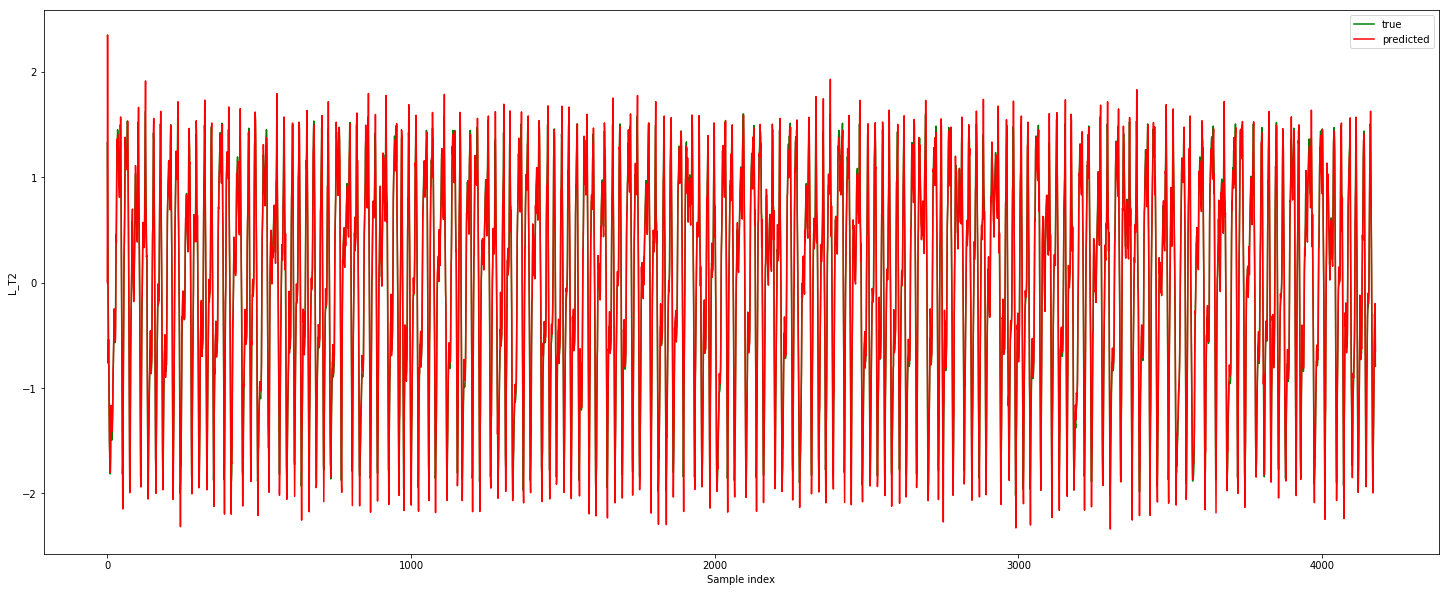

In [5]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T2")

In [6]:
# predictions = np.load('data/arma_44_LT2_scaled.npy')
# opt_p, opt_q = 4, 4

multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.01
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likel

S:  [0.49939004 0.49511611 0.49078191 0.48877012 0.50618464 0.49905543
 0.49473885 0.49404115 0.49815021 0.4940597  0.49459701 0.49473134
 0.49473134 0.49486567 0.49486567 0.495      0.495     ] 

ind:  4


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Confusion matrix:
 [[ 302 2251]
 [ 190 1434]] 

Score: 0.506
Accuracy: 0.416
Precision: 0.118
Recall: 0.614
F1_score: 0.198


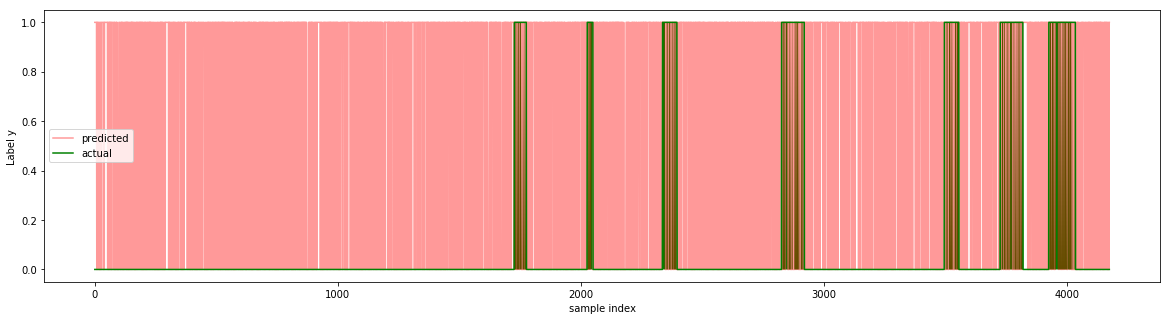

In [7]:
# ind = 6
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

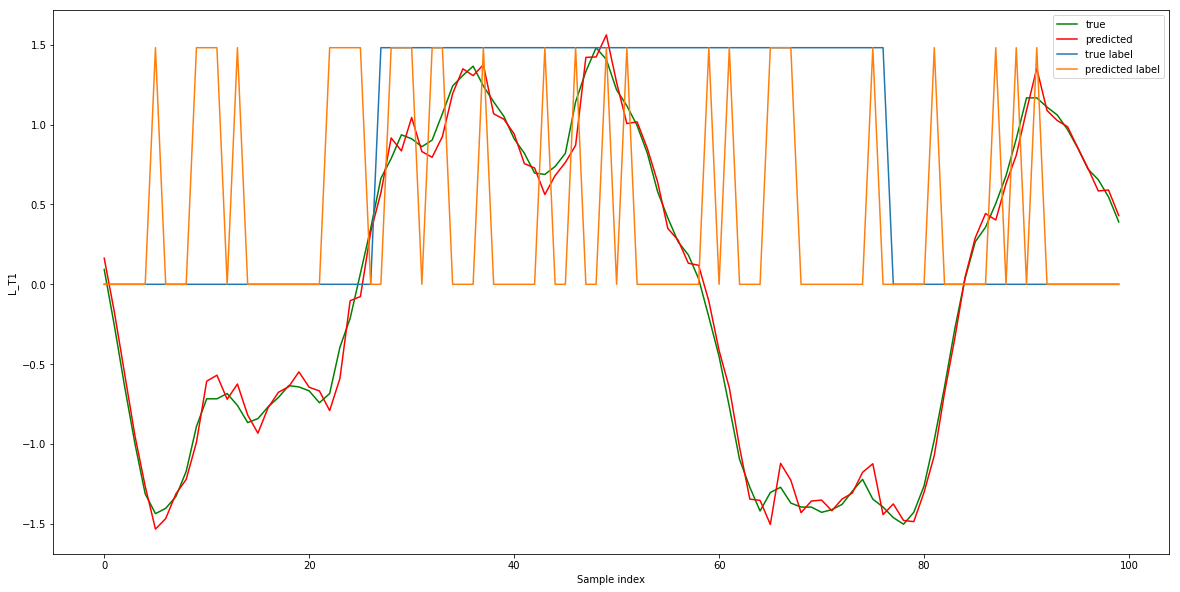

In [11]:
start = 1700
end = 1800

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*np.max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*np.max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

#### Examined sensor: `L_T2`
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_signal = X1_scaled[:, 1]
test_signal = X2_scaled[:, 1]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  4348.816214071157
BIC:  4370.050410069157
DW-test:  0.3887363506536111


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

Regarding `L_T1` we can see that there is positive correlation with both lagged versions of the signal, as well as with lagged residuals. Hence an ARMA method is indeed required. Regarding the Autcorrelation plot we can see that after 4 lags autocorrelation drops significantly. There are though significant autocorrelation for higher lag values, which is not a welcome effect, but we will prefer a simpler model (lower p value). Regarding the PACF plot there is significant drop after a single lag, hence we would choose for q=1.

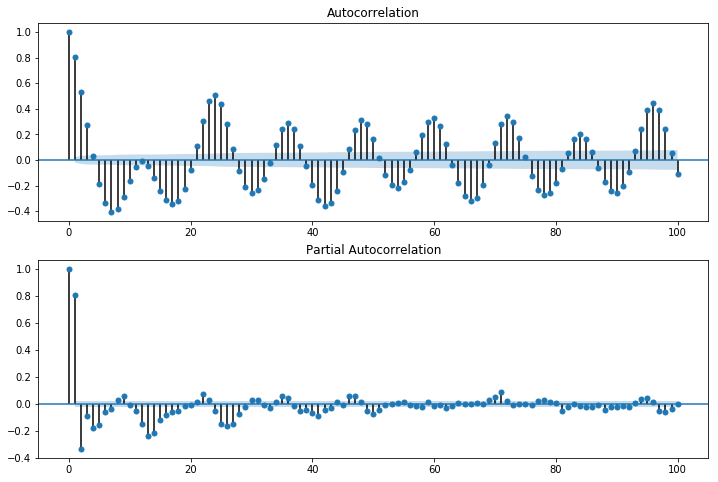

In [3]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [16]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q)

print(AIC)
print(f"Model with min AIC: {np.min(AIC)}, of order: ({opt_p}, {opt_q})")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


Failed to fit ARMA model (3, 3)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[[ 4348.81621407 -2247.36257148 -4755.40401974 -5542.44457987
  -6099.62634171 -6395.76496345]
 [-6748.75697533 -6939.96173303 -6954.25730043 -6952.43650764
  -7009.09173236 -7071.43472911]
 [-6913.56171054 -6951.93917171 -7049.43062249 -7047.45292841
  -7173.20536423 -7233.91689512]
 [-6950.0940682  -7039.76929962 -7047.4641857      0.
  -8560.96786586 -8605.05034107]
 [-6964.07276405 -7040.7589772  -7318.78189289            nan
  -8591.39442323 -8618.95243063]]
Model with min AIC: nan, of order: (5, 3)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Fit optimal model

In [17]:
# summary of the fitted model
opt_p, opt_q = 4, 4
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(4, 4)   Log Likelihood                4290.484
Method:                       css-mle   S.D. of innovations              0.148
Date:                Wed, 29 May 2019   AIC                          -8560.968
Time:                        22:14:12   BIC                          -8490.187
Sample:                             0   HQIC                         -8536.851
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039        nan        nan        nan         nan         nan
ar.L1.y        3.5964        nan        nan        nan         nan         nan
ar.L2.y       -5.1503   3.11e-05  -1.65e+05      0.0

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Max:  0.8382427182257604
Mean:  0.00037033909131139016
std:  0.14849344099792125


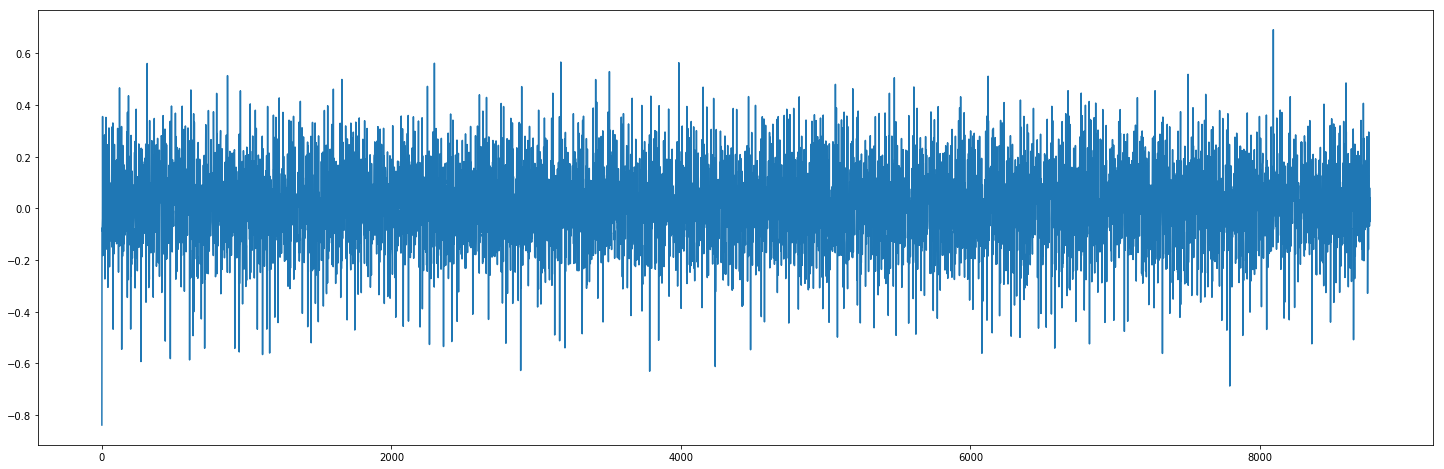

In [18]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [3]:
file = './data/arma_44_LT2_scaled.npy'
opt_p, opt_q = 4, 4
predictions, MFE, MAE, MAPE = predictS(train_signal, test_signal, opt_p, opt_q, file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)
print(f"MAPE: {MAPE*100}%")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:934: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)


MFE:  -5.741048746720458e-05
MAE:  0.12463791632225084
MAPE: 43.901%


Text(0, 0.5, 'L_T2')

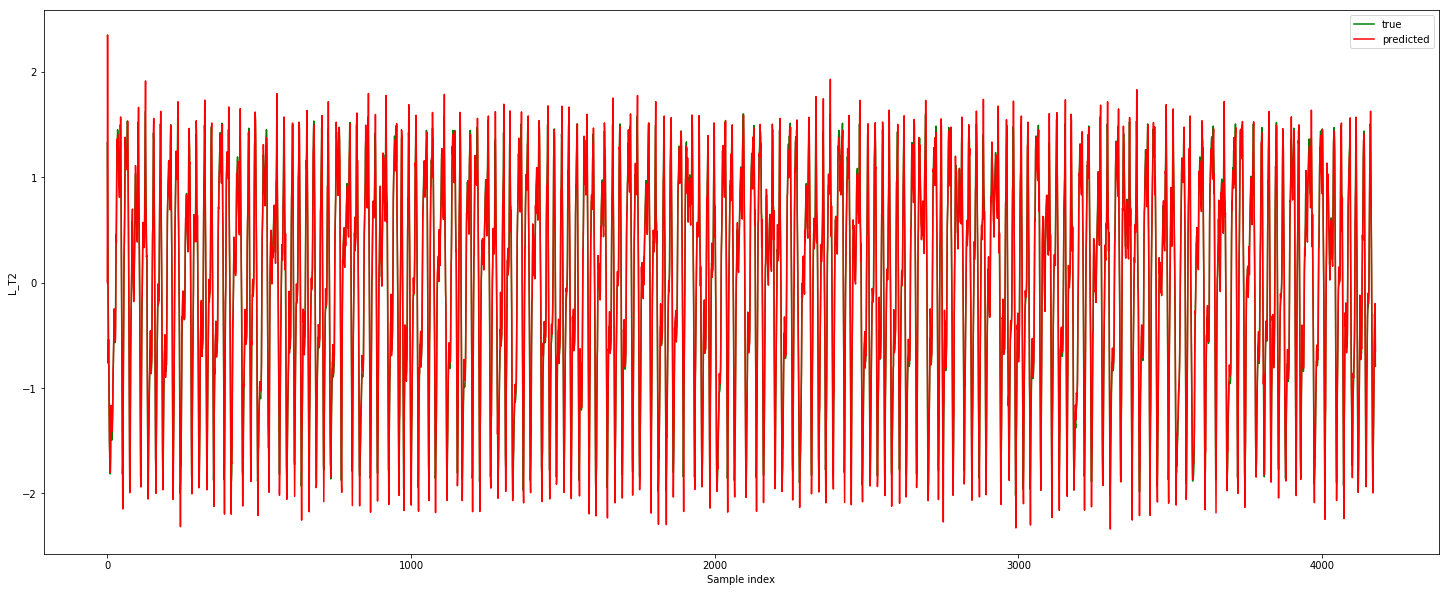

In [5]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T2")

In [6]:
# predictions = np.load('data/arma_44_LT2_scaled.npy')
# opt_p, opt_q = 4, 4

multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.01
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likel

S:  [0.49939004 0.49511611 0.49078191 0.48877012 0.50618464 0.49905543
 0.49473885 0.49404115 0.49815021 0.4940597  0.49459701 0.49473134
 0.49473134 0.49486567 0.49486567 0.495      0.495     ] 

ind:  4


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Confusion matrix:
 [[ 302 2251]
 [ 190 1434]] 

Score: 0.506
Accuracy: 0.416
Precision: 0.118
Recall: 0.614
F1_score: 0.198


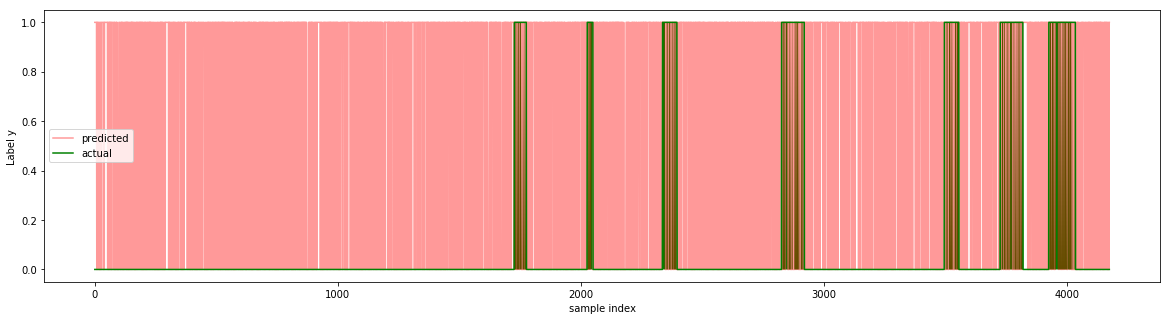

In [7]:
# ind = 6
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

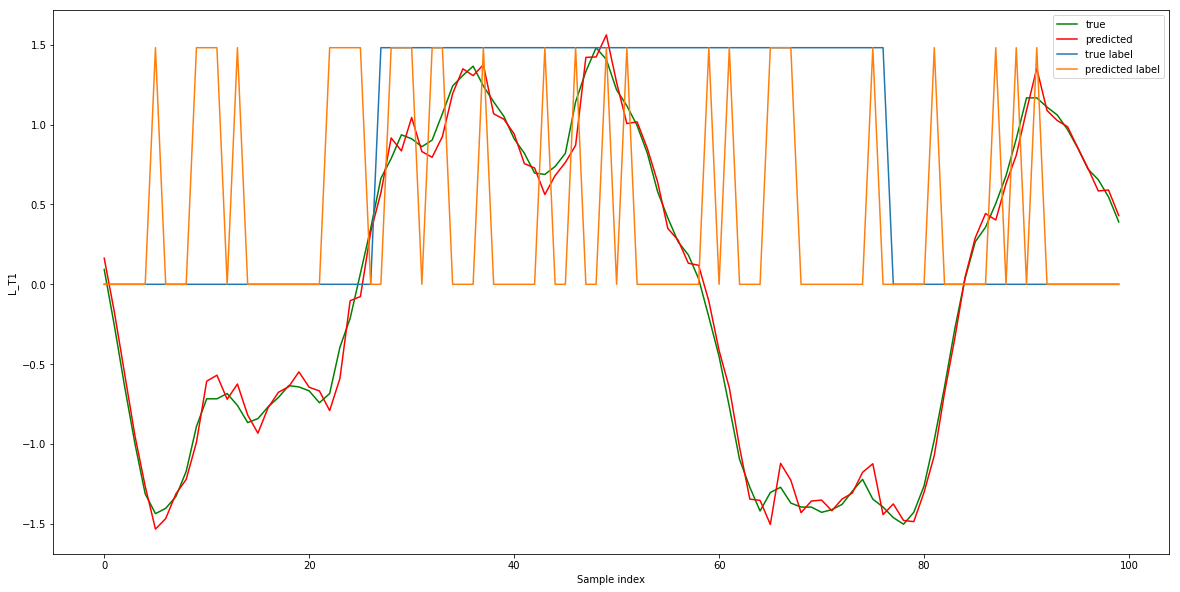

In [11]:
start = 1700
end = 1800

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*np.max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*np.max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

#### Examined sensor: `L_T7`
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_signal = X1_scaled[:, 6]
test_signal = X2_scaled[:, 6]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  19671.491696983147
BIC:  19692.725892981147
DW-test:  1.3816756274195852


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

Regarding `L_T1` we can see that there is positive correlation with both lagged versions of the signal, as well as with lagged residuals. Hence an ARMA method is indeed required. Regarding the Autcorrelation plot we can see that after 4 lags autocorrelation drops significantly. There are though significant autocorrelation for higher lag values, which is not a welcome effect, but we will prefer a simpler model (lower p value). Regarding the PACF plot there is significant drop after a single lag, hence we would choose for q=1.

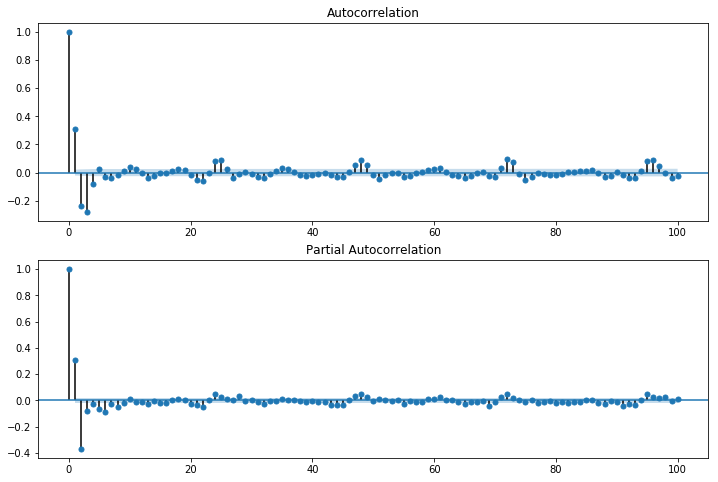

In [9]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [10]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q)

print(AIC)
print(f"Model with min AIC: {np.min(AIC)}, of order: ({opt_p}, {opt_q})")

Failed to fit ARMA model (4, 4)
Failed to fit ARMA model (4, 5)
[[19671.49169698 17726.34029132 17445.20617835 17374.61089209
  17332.86785957 17326.85348306]
 [17570.54647196 17391.55830433 17366.20642678 17372.23190548
  17327.81719416 17328.85348295]
 [17379.18578683 17379.10119531 17366.87818787 17353.49003238
  17328.16522447 17328.49731604]
 [17377.25816103 17351.52692212 17333.18165135 17334.34165695
  17328.40552695 17329.71871157]
 [17339.06837428 17334.85251708 17334.46969537 17328.62963242
      0.             0.        ]]
Model with min AIC: 0.0, of order: (5, 4)


#### Fit optimal model

In [11]:
# summary of the fitted model
opt_p, opt_q = 3, 2
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(3, 2)   Log Likelihood               -8676.439
Method:                       css-mle   S.D. of innovations              0.651
Date:                Wed, 29 May 2019   AIC                          17366.878
Time:                        23:13:15   BIC                          17416.425
Sample:                             0   HQIC                         17383.760
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.017     -0.017      0.986      -0.033       0.033
ar.L1.y        0.6226      0.093      6.705      0.000       0.441       0.805
ar.L2.y       -0.3224      0.075     -4.281      0.0

Max:  2.4777158669687678
Mean:  3.631089677892991e-06
std:  0.6516093984295198


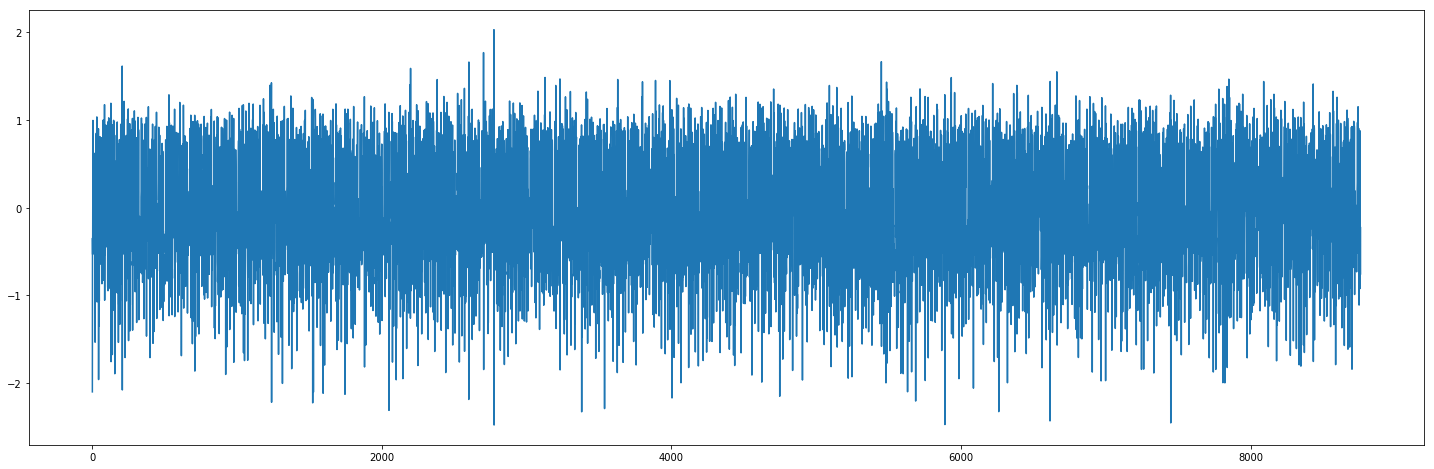

In [12]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [13]:
file = './data/arma_32_LT7_scaled.npy'
opt_p, opt_q = 4, 4
predictions, MFE, MAE, MAPE = predictS(train_signal, test_signal, opt_p, opt_q, file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)
print(f"MAPE: {MAPE*100}%")

MFE:  -4.6446203698568256e-05
MAE:  0.5295210431206271
MAPE: 199.008%


Text(0, 0.5, 'L_T2')

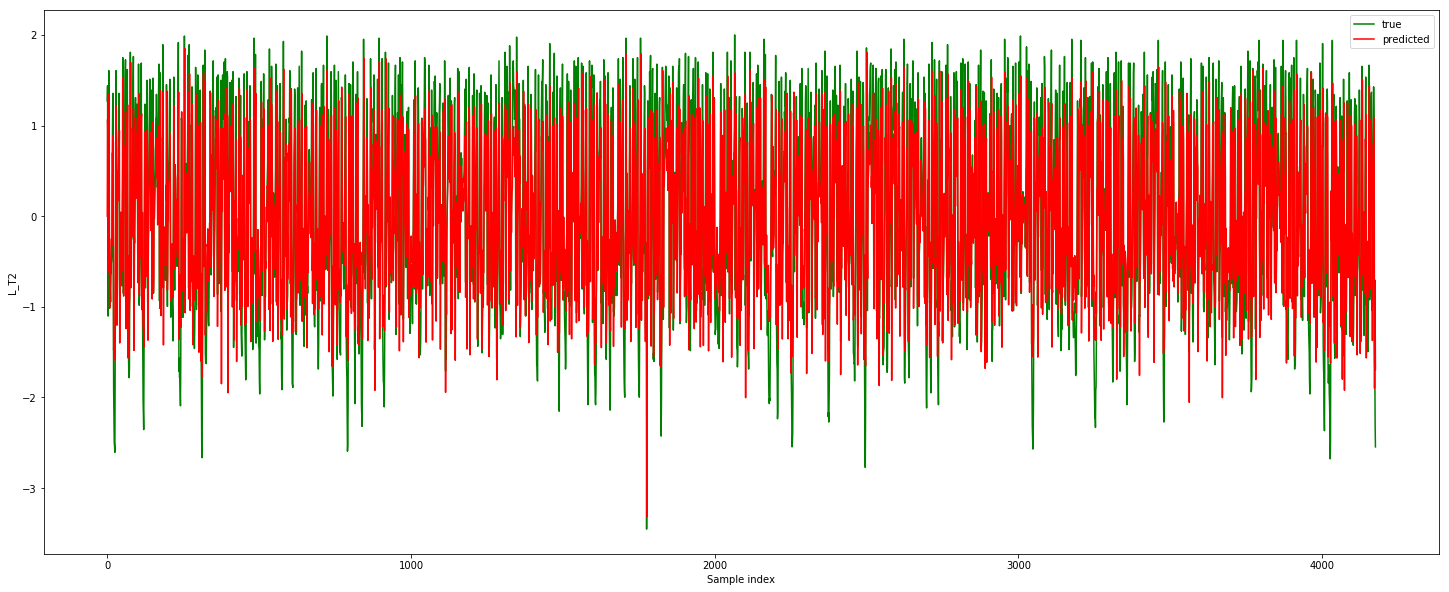

In [14]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T2")

In [15]:
# predictions = np.load('data/arma_32_LT7_scaled.npy')
# opt_p, opt_q = 3, 2

multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.01
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

S:  [0.50513979 0.5072217  0.49621096 0.49958155 0.50452735 0.51538955
 0.50743064 0.50360492 0.49781033 0.49606324 0.495      0.495
 0.495      0.495      0.495      0.495      0.495     ] 

ind:  5


Confusion matrix:
 [[ 229 1636]
 [ 263 2049]] 

Score: 0.515
Accuracy: 0.545
Precision: 0.123
Recall: 0.465
F1_score: 0.194


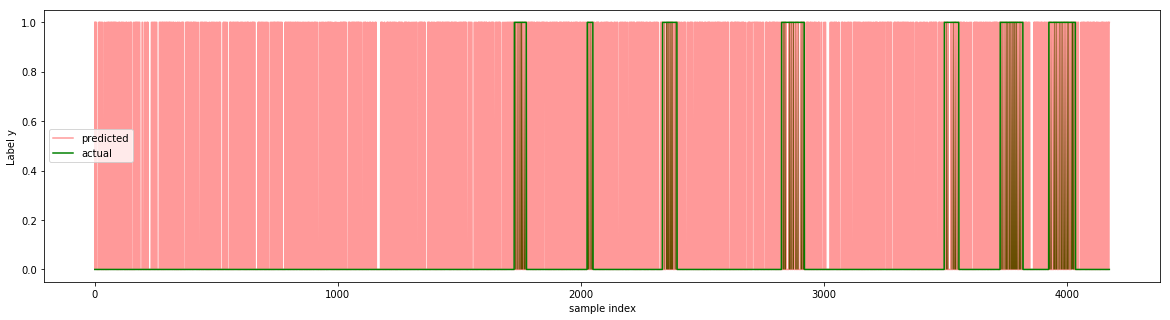

In [16]:
# ind = 6
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

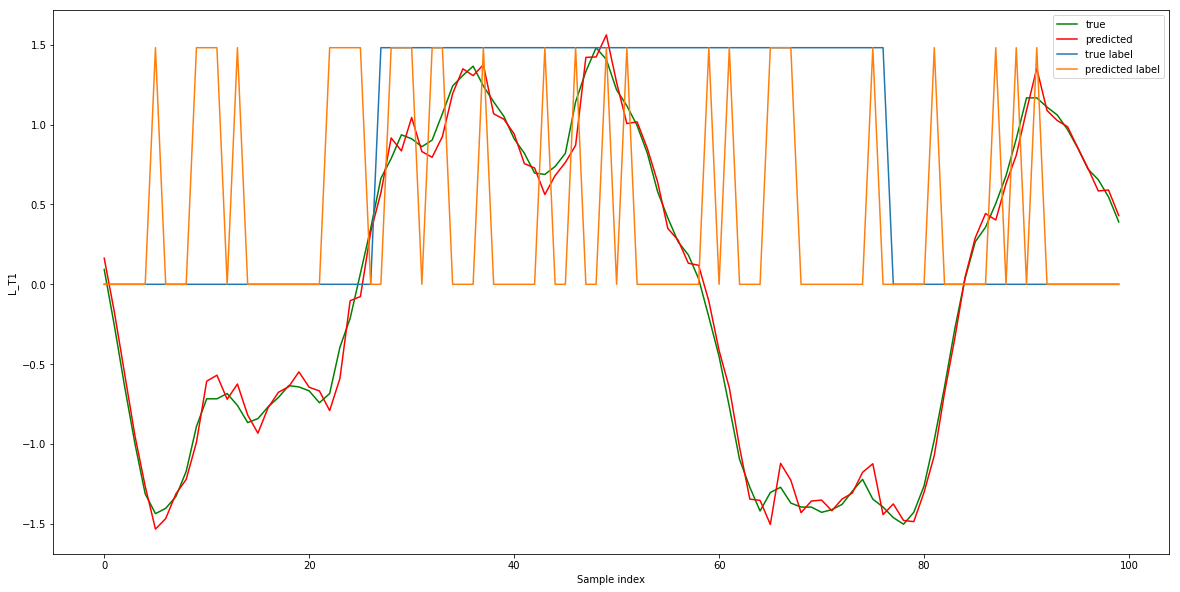

In [11]:
start = 1700
end = 1800

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*np.max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*np.max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

#### Examined sensor: `F_PU1`
First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_signal = X1_scaled[:, 7]
print(train_signal)
test_signal = X2_scaled[:, 7]
model = ARMA(endog=train_signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

[-0.19183717 -0.18213798 -0.24930946 ... -0.3977851  -0.37017727
 -0.47932769]
AIC:  11225.316135297338
BIC:  11246.550331295337
DW-test:  1.9039647817782872


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

Regarding `L_T1` we can see that there is positive correlation with both lagged versions of the signal, as well as with lagged residuals. Hence an ARMA method is indeed required. Regarding the Autcorrelation plot we can see that after 4 lags autocorrelation drops significantly. There are though significant autocorrelation for higher lag values, which is not a welcome effect, but we will prefer a simpler model (lower p value). Regarding the PACF plot there is significant drop after a single lag, hence we would choose for q=1.

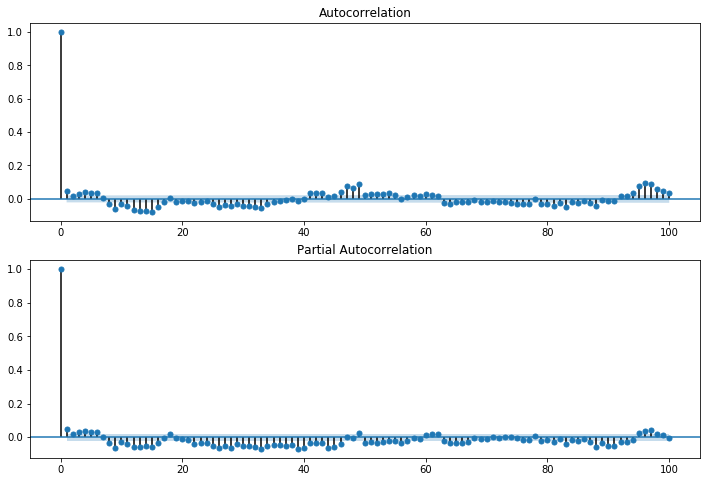

In [24]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model based on AIC

In [25]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(0,6, dtype=int)

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q)

print(AIC)
print(f"Model with min AIC: {np.min(AIC)}, of order: ({opt_p}, {opt_q})")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optim

[[11225.3161353  11203.48825973 11198.63554851 11186.54048736
  11166.49273564 11140.33509454]
 [11201.80871919 10572.9176607  10565.3205443  10540.71689988
  10535.92067495 10537.80146434]
 [11194.47020783 10566.47441012 10507.51739586 10536.81480445
  10537.8435392  10508.30444217]
 [11171.69787111 10543.95375874 10536.43496068 10510.98051666
  10442.01040441 10420.06582788]
 [11130.7326588  10536.34648718 10537.21981472 10539.12676091
  10454.74737447 10439.97599731]]
Model with min AIC: 10420.065827878003, of order: (4, 5)


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


#### Fit optimal model

In [26]:
# summary of the fitted model
opt_p, opt_q = 1, 0
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(1, 0)   Log Likelihood               -5609.658
Method:                       css-mle   S.D. of innovations              0.459
Date:                Wed, 29 May 2019   AIC                          11225.316
Time:                        23:51:22   BIC                          11246.550
Sample:                             0   HQIC                         11232.551
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.044     -0.014      0.989      -0.087       0.085
ar.L1.y        0.8884      0.005    181.244      0.000       0.879       0.898
                                    Roots           

Max:  2.882576107057355
Mean:  1.9384630279444934e-05
std:  0.4589928126481768


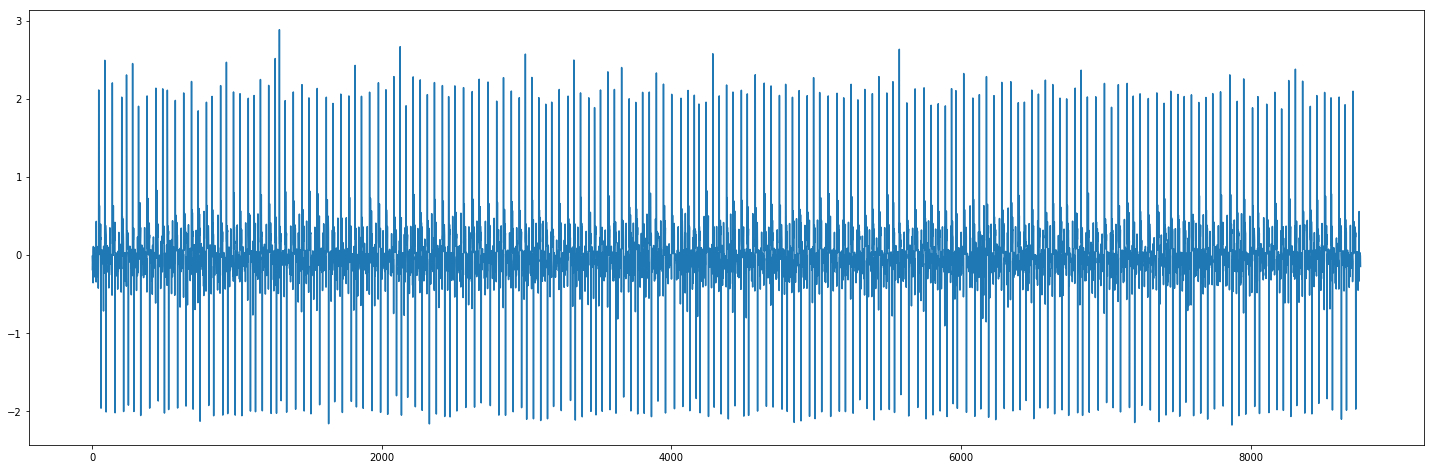

In [27]:
plt.figure(figsize=(25,8))
plt.plot(model_fit.resid)
print("Max: ", max(np.abs(model_fit.resid)))
print("Mean: ", np.mean(model_fit.resid))
print("std: ", np.std(model_fit.resid))

#### Predict and detect anomailes based on the set threshold

In [28]:
file = './data/arma_10_F_PU1_scaled.npy'
opt_p, opt_q = 1, 0
predictions, MFE, MAE, MAPE = predictS(train_signal, test_signal, opt_p, opt_q, file, print_output=False)
print("MFE: ", MFE)
print("MAE: ", MAE)
print(f"MAPE: {MAPE*100}%")

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:934: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/numpy/linalg/linalg.py:1855: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


MFE:  0.0004057842468782333
MAE:  0.2284158429537466
MAPE: 38.933%


Text(0, 0.5, 'L_T1')

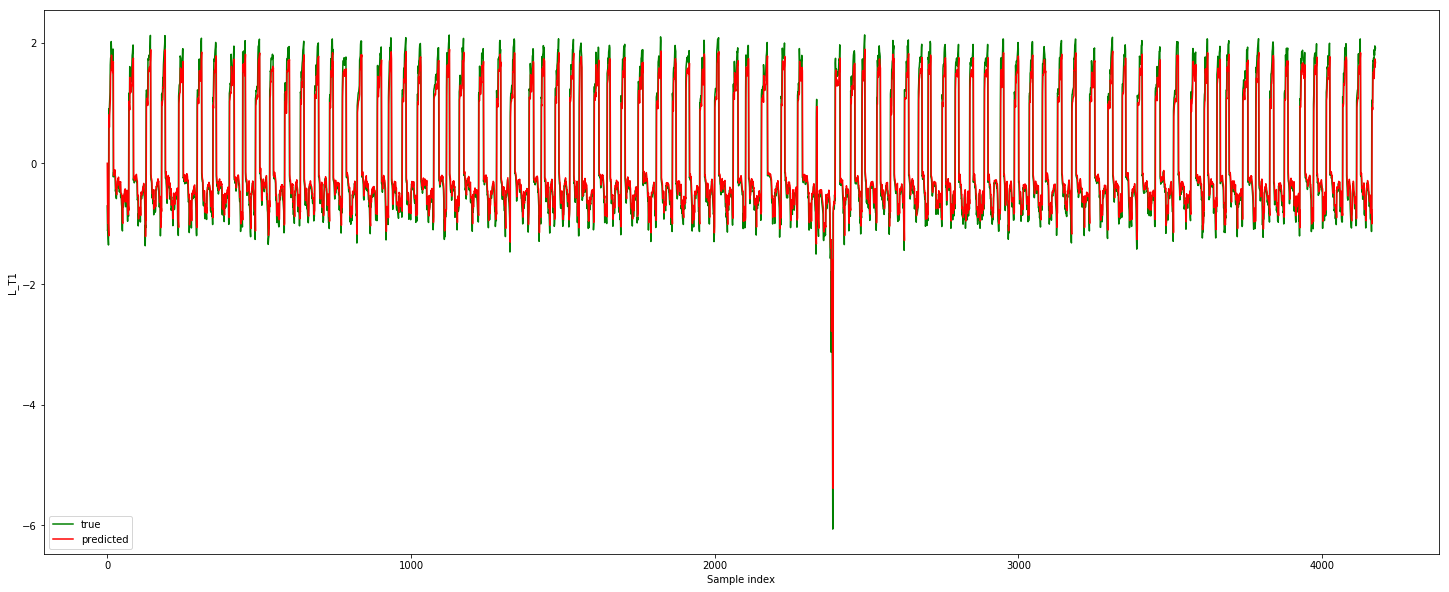

In [29]:
plt.figure(figsize=(25,10))
plt.plot(test_signal, color = 'g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")

In [30]:
# predictions = np.load('data/arma_21_LT1_scaled.npy')
# opt_p, opt_q = 2, 1

multiplier = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15])
S = np.zeros(len(multiplier))
gamma = 0.01
for i in range(len(multiplier)):
    threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[i])
    alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)
    
    predicted_labels = np.zeros_like(y2)
    predicted_labels[alarm_ind] = 1
    S[i] = compute_s(y2, predicted_labels, gamma)

ind = np.argmax(S)
print("S: ", S, "\n")
print("ind: ", ind)

S:  [0.50038615 0.49943739 0.50688962 0.52305789 0.5125726  0.50490478
 0.50628566 0.50604109 0.50402889 0.50145293 0.49668917 0.49619657
 0.49619657 0.49619657 0.495      0.495      0.495     ] 

ind:  3


Confusion matrix:
 [[ 307 2162]
 [ 185 1523]] 

Score: 0.523
Accuracy: 0.438
Precision: 0.124
Recall: 0.624
F1_score: 0.207


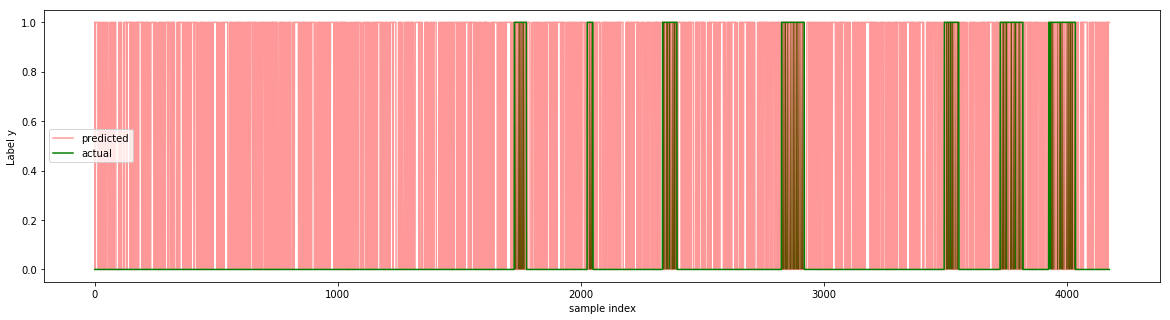

In [34]:
# ind = 3
threshold_up, threshold_down = determine_threshold(train_signal, opt_p, opt_q, multiplier[ind])
alarm_ind = extract_alarm_indices(test_signal, predictions, threshold_up, threshold_down)

predicted_labels = np.zeros_like(y2)
predicted_labels[alarm_ind] = 1

cm = estimate_confusion_matrix(y2, predicted_labels)
print("Confusion matrix:\n", cm, "\n")

s = compute_s(y2, predicted_labels, gamma)
accuracy, precision, recall, F1_score = performance_metrics(cm)
print("Score: %.3f" %s)
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" %precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" %F1_score)

plot(y2, predicted_labels)

Text(0, 0.5, 'L_T1')

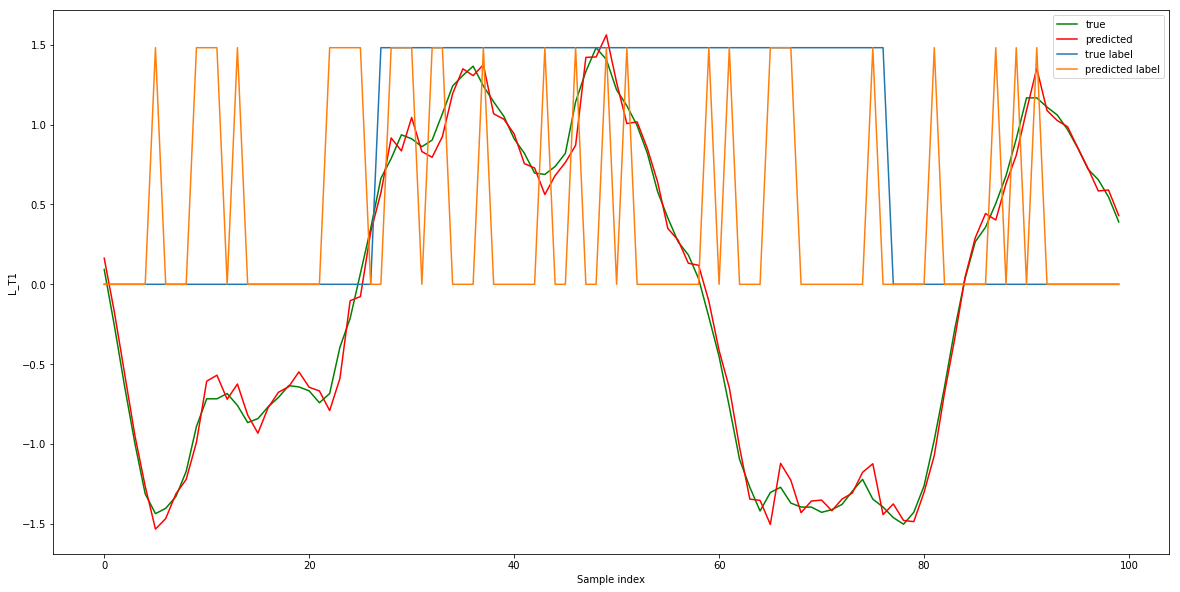

In [11]:
start = 1700
end = 1800

plt.figure(figsize=(20,10))
plt.plot(test_signal[start:end], color = 'g', label='true')
plt.plot(predictions[start:end], color='r', label='predicted')
plt.plot(y2[start:end]*np.max(test_signal[start:end]), label='true label')
plt.plot(predicted_labels[start:end]*np.max(test_signal[start:end]), label='predicted label')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("L_T1")